# Tutorial: training kilonova surrogate models in $\texttt{NMMA}$

**Abstract:** NMMA allows users to build surrogate models/emulators from grids of simulations of various kilonova (KN) models. In case you want to get your hands dirty and adapt or extend the kilonova modelling, it could be helpful to break down the source code and see the intermediate steps that are performed in building these models to for instance gain insight into the training data. This notebook shows the different preprocessing steps before building the models as guideline to users. Afterwards, we train a neural network with Tensorflow as surrogate model.

In [10]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import nmma

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16
        }

plt.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

We will train a surrogate model of the `Bu2022Ye`` model. The lightcurves are generated based on the $\texttt{POSSIS}$ code, for which the paper can be found [here](https://arxiv.org/abs/1906.04205). The kilonova model used has two distinct ejecta components:
- a “lanthanide-rich” component distributed around the merger plane with half-opening angle $\Phi$, and
- a “lanthanide-free” component distributed at higher latitudes.

A schematic diagram is shown below. These are often referred to as the dynamical ejecta and disk wind, respectively. The parameters of this model are:
- dynamical ejecta mass $M_{\rm{ej}}^{dyn}$
- disk wind ejecta mass $M_{\rm{ej}}^{wind}$
- half opening angle $\Phi$
- observation angle $\Theta_{\rm{obs}}$
- the electron fraction $Y_e$


![Bulla KN model geometry](https://www.researchgate.net/publication/329042213/figure/fig1/AS:731591093547014@1551436317331/Sketch-of-the-fiducial-kilonova-model-used-in-this-work-A-meridional-cross-section-of-the.png)

## Exploring and preprocessing data

For this tutorial, we will build a surrogate model of the Bulla model. We have to point to the relevant directory where the raw data (the lightcurves) are located. In this case, we have 7700 different lightcurves.

In [11]:
# Location of the kilonova lightcurves
lcs_dir = "/home/urash/twouters/KN_Lightcurves/lightcurves/lcs_bulla_2022"
filenames = os.listdir(lcs_dir)
full_filenames = [os.path.join(lcs_dir, f) for f in filenames]
print(f"There are {len(full_filenames)} lightcurves for this model.")

There are 7700 lightcurves for this model.


For this specific kilonova models, the files have a specific naming convention which gives the values of the parameters of this model, as can be seen from an example below. (Note that the first variable nph refers to the number of photon packets used in the simulation code)

In [12]:
filenames[0] # get an example file name

'nph1.0e+06_dyn0.005-0.12-0.30_wind0.050-0.03_theta25.84_dMpc0.dat'

These files contain the synthetic lightcurves corresponding to these parameter values. To briefly explore the lightcurve data, let us load in a single lightcurve. These lightcurves contain a time column `t`, forming the time grid (in days) at which lightcurve data is given. The remaining columns give the lightcurves for various filters.

> **NOTE** To read in lightcurve files with `nmma`, one can use the function `read_lightcurve_file` in `nmma/em/io` or the `read_photometry_files`, with in our case `datatype` set to `"bulla"`.

In [13]:
dat = pd.read_csv(full_filenames[0], delimiter=" ", escapechar='#')
dat = dat.rename(columns={" t[days]": "t"})
dat.head() # show first few rows

,t,bessellux,bessellb,bessellv,bessellr,besselli,sdssu,ps1::g,ps1::r,ps1::i,...,uvot::white,atlasc,atlaso,2massj,2massh,2massks,ztfg,ztfr,ztfi,Unnamed: 27
0,0.103,-15.361,-15.377,-15.192,-14.957,-15.142,-15.400,-15.083,-15.069,-14.145,...,-15.522,-15.189,-14.757,-14.788,-11.856,12.727,-15.223,-14.879,-14.911,NaN
1,0.109,-17.981,-18.327,-17.994,-17.865,-17.313,-18.045,-18.107,-17.978,-17.423,...,-18.421,-17.913,-17.795,-13.012,-13.678,-3.248,-18.047,-17.902,-17.417,NaN
2,0.116,-18.303,-17.752,-17.570,-17.637,-17.101,-18.346,-17.857,-17.512,-17.707,...,-18.376,-17.727,-17.652,-13.518,-16.154,-11.411,-17.893,-17.696,-17.301,NaN
3,0.122,-18.193,-17.729,-17.856,-17.870,-17.120,-18.175,-17.523,-17.874,-16.992,...,-18.381,-17.791,-17.614,-16.271,-17.455,-15.149,-17.562,-17.835,-16.881,NaN
4,0.130,-18.391,-18.425,-17.740,-17.651,-17.797,-18.361,-18.217,-17.755,-17.160,...,-18.325,-18.074,-17.532,-16.811,-13.814,-5.180,-18.237,-17.698,-17.634,NaN


An overview of the different filters that are in the Bu2022Ye model is given below:

In [14]:
value_columns = dat.columns[1:-1] # discard first and last, to get "true" data columns
print(list(value_columns))

['bessellux', 'bessellb', 'bessellv', 'bessellr', 'besselli', 'sdssu', 'ps1::g', 'ps1::r', 'ps1::i', 'ps1::z', 'ps1::y', 'uvot::b', 'uvot::u', 'uvot::uvm2', 'uvot::uvw1', 'uvot::uvw2', 'uvot::v', 'uvot::white', 'atlasc', 'atlaso', '2massj', '2massh', '2massks', 'ztfg', 'ztfr', 'ztfi']


Now, we make a plot of the lightcurves in one of the files to get a sense of how the lightcurves look like. The y axis contains the magnitude of the corresponding filter.

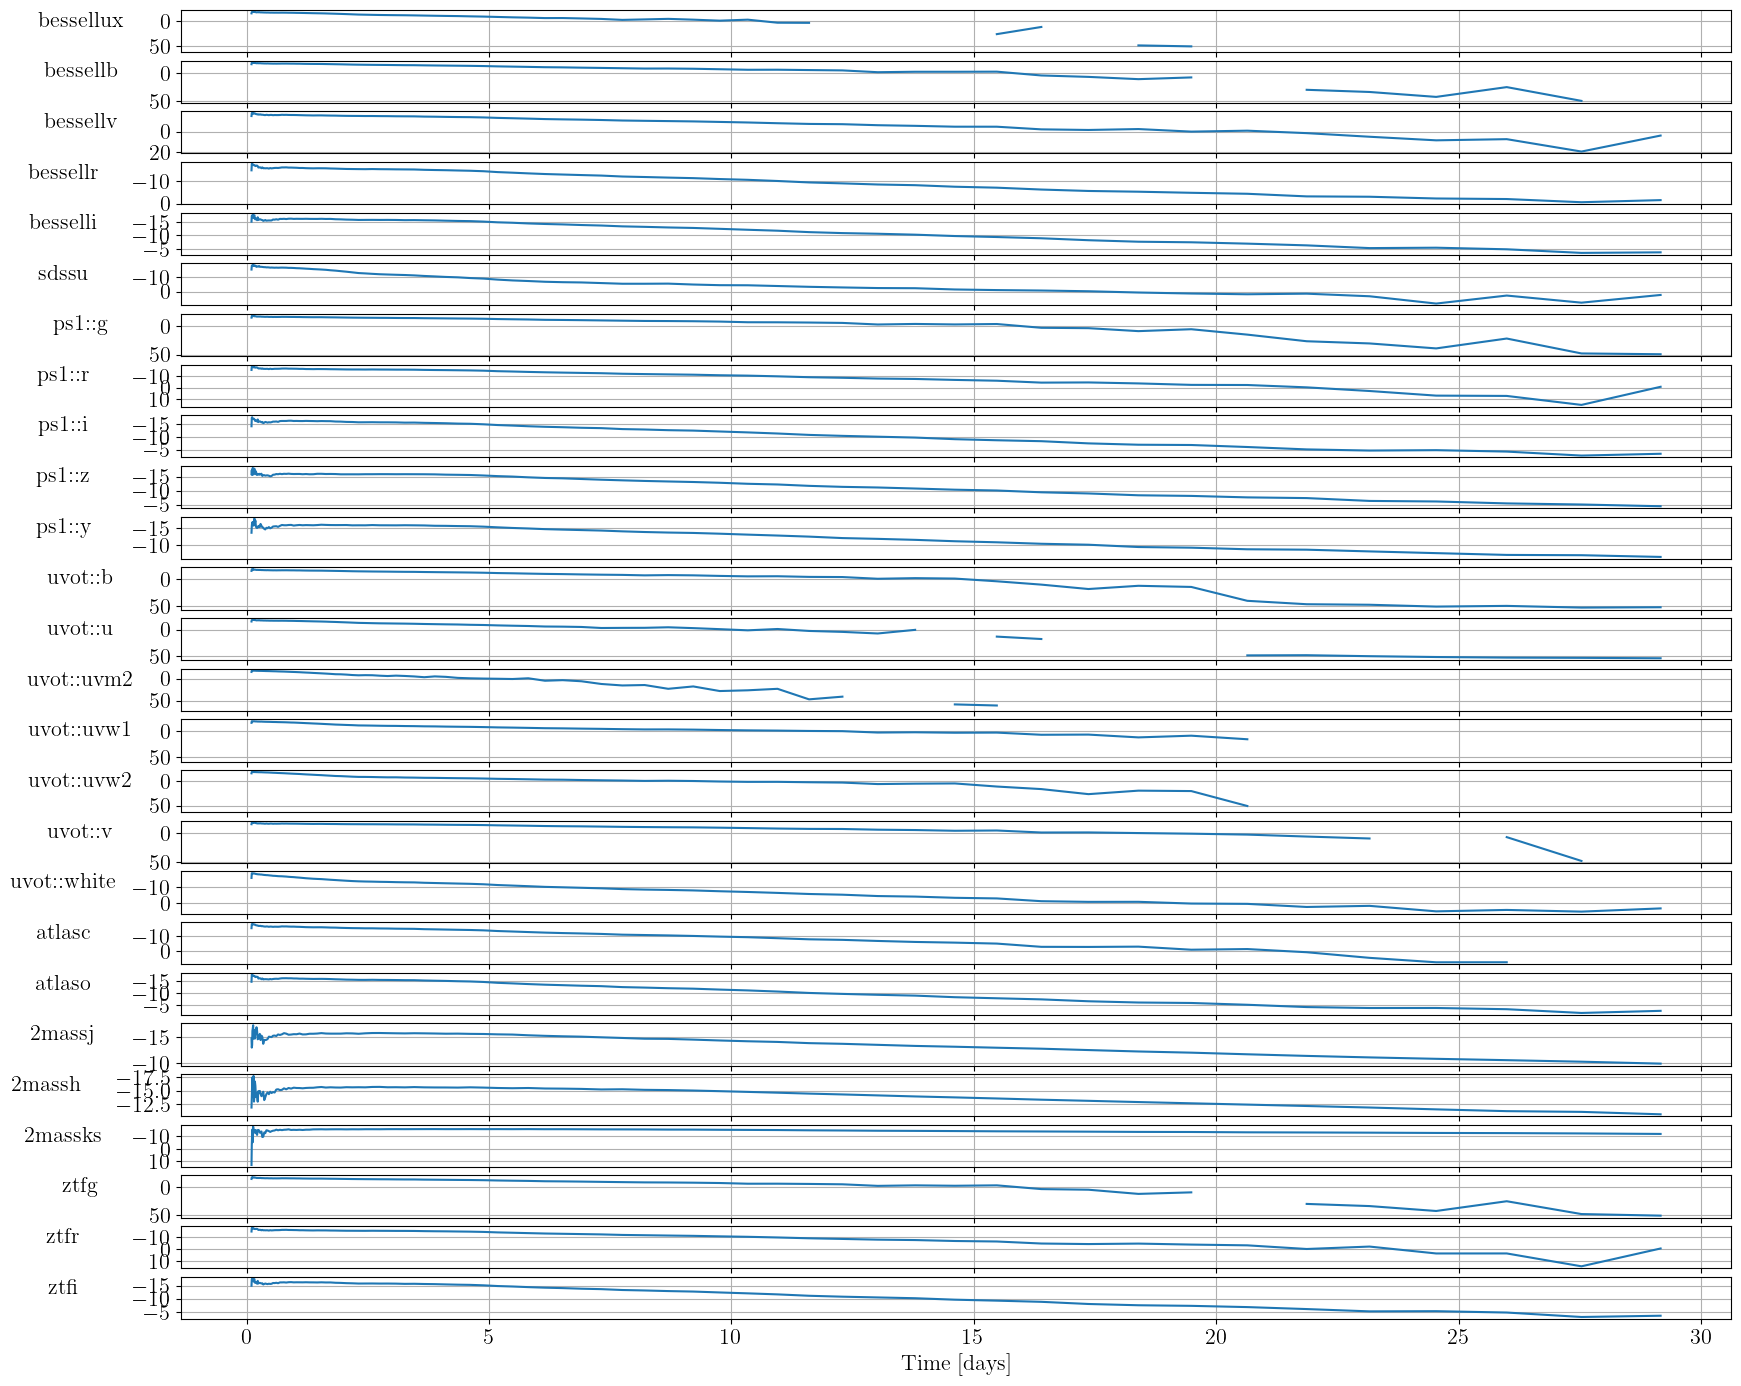

In [15]:
nrow = len(value_columns)
fig, axs = plt.subplots(nrow, 1, figsize=(20, 17), sharex = True)
t = dat["t"].values

for i, key in enumerate(value_columns):
    plt.subplot(nrow, 1, i+1)
    plt.plot(t, dat[key].values)
    plt.ylabel(key, rotation=0, labelpad=50)
    axs[i].invert_yaxis()
    # plt.grid()
plt.xlabel("Time [days]")
plt.show()

Now, there are two preprocessing steps to do:
- Read all the lightcurves and preprocess the data to account for missing values (NaNs)
- Get the parameters of the KN model from the filenames

## Get preprocessed lightcurves

For the former, we use the `read_photometry_files` function from NMMA from the `nmma/em/io` script. This creates a dictionary containing photometric data. The keys correspond to the filenames of the data. The values are dictionaries of which the keys correspond to time (t) or the filters considered. The corresponding values are the time grid (in days) and the magnitudes of the different filters. We then use the `interpolate_nans` function from `nmma/em/utils` to deal with NaNs. The result will be stored in `data`. **Note:** This can take a while if you have a large grid. 

In [16]:
from nmma.em.io import read_photometry_files
from nmma.em.utils import interpolate_nans

In [17]:
data = read_photometry_files(full_filenames)
data = interpolate_nans(data)

For convenience, we will seperately define the filters we are using in this dataset of lightcurves under `filts`, since that will reappear regularly during this tutorial:

In [18]:
keys = list(data.keys())
filts = sorted(list(set(data[keys[0]].keys()) - {"t"}))
print(filts)

['2massh', '2massj', '2massks', 'atlasc', 'atlaso', 'bessellb', 'besselli', 'bessellr', 'bessellux', 'bessellv', 'ps1__g', 'ps1__i', 'ps1__r', 'ps1__y', 'ps1__z', 'sdssu', 'uvot__b', 'uvot__u', 'uvot__uvm2', 'uvot__uvw1', 'uvot__uvw2', 'uvot__v', 'uvot__white', 'ztfg', 'ztfi', 'ztfr']


## Get the model parameters

The filenames of our grid of lightcurves contain the model parameters (masses, velocities, angles) but have to be extracted as numerical values from the filename. For this, $\texttt{NMMA}$ has functions implemented to extract parameter values from the naming conventions of files for their supported models in `nmma/em/model_parameters`. Here is an overview of which lightcurves are supported for extracting the parameters: the keys denote the names of the supported models, and the values are the $\texttt{NMMA}$ functions which perform the extraction

In [19]:
import inspect 
import nmma.em.model_parameters as model_parameters

MODEL_FUNCTIONS = {
    k: v for k, v in model_parameters.__dict__.items() if inspect.isfunction(v)
}
MODEL_FUNCTIONS

{'get_knprops_from_LANLfilename': <function nmma.em.utils.get_knprops_from_LANLfilename(filename)>,
 'AnBa2022_linear': <function nmma.em.model_parameters.AnBa2022_linear(data)>,
 'AnBa2022_log': <function nmma.em.model_parameters.AnBa2022_log(data)>,
 'AnBa2022_sparse': <function nmma.em.model_parameters.AnBa2022_sparse(data)>,
 'CV': <function nmma.em.model_parameters.CV(data)>,
 'Bu2019lm_sparse': <function nmma.em.model_parameters.Bu2019lm_sparse(data)>,
 'Bu2019lm': <function nmma.em.model_parameters.Bu2019lm(data)>,
 'Bu2019nsbh': <function nmma.em.model_parameters.Bu2019nsbh(data)>,
 'Bu2022Ye': <function nmma.em.model_parameters.Bu2022Ye(data)>,
 'Ka2017': <function nmma.em.model_parameters.Ka2017(data)>,
 'LANL2022': <function nmma.em.model_parameters.LANL2022(data)>}

We are using `Bu2022Ye`, so we fetch the function to extract its parameters:

In [20]:
model_name = "Bu2022Ye"
model_function = MODEL_FUNCTIONS[model_name]

# Apply it to our dataset:
training_data, parameters = model_function(data)

All these "model functions" have two return values. The second return value, called `parameters` above, simply lists the names of the model parameter:


In [21]:
print(parameters)

['log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'KNtheta']


The first, which we call `training_data` here, is a dictionary containing all the information regarding the lightcurves. The keys of this dictionary correspond to the filenames. The values are again dictionaries, which give the names and values of the model parameters, the time grid, and the filter data, similar to what was shown above. We give an example below. Note how the model parameters match the values given in the filename.

In [22]:
example_key = list(training_data.keys())[0]
example_training_data = training_data[example_key]
print(f"Keys (and some values) of dictionary of {example_key}")
for key in example_training_data.keys():
    value = example_training_data[key]
    if key in parameters:
        print(f"{key} : {value}")
    else:
        print(key)

Keys (and some values) of dictionary of nph1.0e+06_dyn0.005-0.12-0.30_wind0.050-0.03_theta25.84_dMpc0
log10_mej_dyn : -2.3010299956639813
vej_dyn : 0.12
Yedyn : 0.3
log10_mej_wind : -1.3010299956639813
vej_wind : 0.03
KNtheta : 25.84
t
bessellux
bessellb
bessellv
bessellr
besselli
sdssu
ps1__g
ps1__r
ps1__i
ps1__z
ps1__y
uvot__b
uvot__u
uvot__uvm2
uvot__uvw1
uvot__uvw2
uvot__v
uvot__white
atlasc
atlaso
2massj
2massh
2massks
ztfg
ztfr
ztfi


## Getting the SVD model

Emulators are not trained on the raw lightcurve data. Instead, one first performs a [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) to project the data into a lower-dimensional representation. By default, $\texttt{NMMA}$ projects the lightcurves onto a 10-dimensional space. This preprocessing step is performed with an `SVDTrainingModel` object, which is located in `nmma/em/training`. By default, initializing this object automatically starts training a model. We will delay this for the purpose of this tutorial.

> **Note** We store `training_data` in the `data` field of this `training_model` object.

In [23]:
from nmma.em.training import SVDTrainingModel
svd_ncoeff = 10
training_model = SVDTrainingModel(
        model_name,
        training_data,
        parameters,
        t,
        filts,
        n_coeff=svd_ncoeff,
        interpolation_type="tensorflow",
        start_training=False # don't train, just prep the data
    )

The grid will be interpolated to sample_time with interp1d
Model exists... will load that model.


2023-11-08 15:31:20.708356: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 15:31:20.864258: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 15:31:21.590890: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-08 15:31:21.590958: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

downloading 1 files for model Bu2022Ye_tf:


Bu2022Ye_tf.pkl: 0.00iB [00:00, ?iB/s]

2023-11-08 15:31:23.846054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 15:31:25.769277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4222 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:73:00.0, compute capability: 7.5


Now, we generate the SVD model. This function normalizes both the parameter values and the lightcurve data to a [0, 1] range. That is, if the data $x$ varies between $[x_{\rm{min}}, x_{\rm{max}}]$, then we normalize the data to a new variable $\tilde{x}$ with the transformation
$$\tilde{x} = \frac{x - x_{\rm{min}}}{x_{\rm{max}} - x_{\rm{min}}} $$
such that $\tilde{x}$ varies between $[0,1]$.

Next, for each filter, a SVD decomposition of the lightcurve data for that filter is performed. **Note:** This can take a while for larger grids.

In [24]:
svd_model = training_model.generate_svd_model()
training_model.svd_model = svd_model

Normalizing mag filter 2massh...
Normalizing mag filter 2massj...
Normalizing mag filter 2massks...
Normalizing mag filter atlasc...
Normalizing mag filter atlaso...
Normalizing mag filter bessellb...
Normalizing mag filter besselli...
Normalizing mag filter bessellr...
Normalizing mag filter bessellux...
Normalizing mag filter bessellv...
Normalizing mag filter ps1__g...
Normalizing mag filter ps1__i...
Normalizing mag filter ps1__r...
Normalizing mag filter ps1__y...
Normalizing mag filter ps1__z...
Normalizing mag filter sdssu...
Normalizing mag filter uvot__b...
Normalizing mag filter uvot__u...
Normalizing mag filter uvot__uvm2...
Normalizing mag filter uvot__uvw1...
Normalizing mag filter uvot__uvw2...
Normalizing mag filter uvot__v...
Normalizing mag filter uvot__white...
Normalizing mag filter ztfg...
Normalizing mag filter ztfi...
Normalizing mag filter ztfr...


Let us have a look at the dictionary of one filter of the SVD model:
- `param_array_postprocess`: Normalized values of the parameters of the KN model
- `param_mins`: $x_{\rm{min}}$ for the parameters in the above explanation
- `param_maxs`: $x_{\rm{max}}$ for the parameters in the above explanation
- `mins`: $x_{\rm{min}}$ for the lightcurve data in the above explanation
- `maxs`: $x_{\rm{max}}$ for the lightcurve data in the above explanation
- `cAmat`: $n_{\rm{coeff}} \times n$ matrix of projected lightcurve data
- `cAstd`: $n_{\rm{coeff}} \times n$ matrix of errors for projected lightcurve data
- `VA`: Matrix $V$ used in the SVD decomposition.
- `tt`: Time grid.

Here, $n$ refers to the number of lightcurves in the training data (7700 here) and $n_{\rm{coeff}}$ is the number of SVD coefficients (taken to be 10 by default in $\texttt{NMMA}$).

More information about the SVD decomposition used can be found in the `np.linalg` documentation [here](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html).

> **Note:** Since the SVD model saves the mins and maxs, we can always undo the normalization and recover the original data.

In [25]:
# Get a specific filter just to show the result
keys = list(training_model.svd_model['2massh'].keys())
print(keys)
print(np.shape(training_model.svd_model['2massh']['cAmat']))
print(np.shape(training_model.svd_model['2massh']['cAstd']))

Install wrapt_timeout_decorator if you want timeout simulations.
['param_array_postprocess', 'param_mins', 'param_maxs', 'mins', 'maxs', 'tt', 'n_coeff', 'cAmat', 'cAstd', 'VA']
(10, 7700)
(10, 7700)


## Training a neural network emulator

Now that we have the postprocessed data, the idea is to train a neural network to emulate the relationship between the KN model parameters and the projected, low-dimensional representation of the lightcurves. In this case, the 7700 examples lightcurves form the training data of this relationship. The purpose of training an emulator is to be able to generate lightcurves for arbitrary parameter values, also values for which we do not have simulated data. Hence, the neural network is said to interpolate between the grid of lightcurves.

Training neural networks is done with [Tensorflow](https://www.tensorflow.org/) in $\texttt{NMMA}$. There are a lot of great tutorials and examples in Tensorflow to get you familiar with the training of neural networks in general. Here, we mainly use simple feedforward fully connected multi-layer perceptrons, *i.e.*, vanilla neural networks.

Following good practice in deep learning, we perform a split of our dataset into a training set (used to tune the parameters of the neural network) and a validation (or "test") set (used to check the performance of the model on unseen data, to guard against overfitting).

In [26]:
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.utils import plot_model

### Prepare the data

We will denote the input of the neural network (also called features) with $X$ and the output (also called labels) with $y$. Let us train on the data of the first filter for simplicity for now. Recall that the input are the model parameters, and that we will use the normalized values. Our dataset has shape $(n, d)$ with $n$ the total size of our dataset, *i.e.* the 7700 lightcurve files, and $d$ the dimensionality of our KN model, which is 6 for the `Bu2022Ye` model. The output is the SVD projected lightcurve data, which has shape $(n, n_{\rm{coeff}})$, as discussed earlier.

In [27]:
first_filter = filts[0]

X = training_model.svd_model[first_filter]['param_array_postprocess'] # complete dataset of input data of network
n_samples, input_ndim = X.shape
print(f"Features (input) have shape {X.shape}")

y = training_model.svd_model[first_filter]['cAmat'].T
_, output_ndim = y.shape
print(f"Labels (output) have shape {y.shape}")

Features (input) have shape (7700, 6)
Labels (output) have shape (7700, 10)


We perform a train-validation split, setting aside 10% of the data for validation and using the remaining data for training.

In [28]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=0)

### Neural network architecture

In principle, the architecture of our neural network is arbitrary and one can spend days finetuning the architecture to get good performance. For the purpose of this tutorial, let us consider a simple and small architecture of a few `Dense`, *i.e.* fully connected, layers and use ReLU activation functions between the hidden layers.

> **Note:** $\texttt{NMMA}$ additionally considers a dropout layer, which we do not include here.

In [29]:
model = Sequential()
model.add(Input((train_X.shape[1],)))
model.add(
    Dense(
        64,
        activation="relu",
        kernel_initializer="he_normal",
    )
)
model.add(
    Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal",
    )
)
model.add(
    Dense(
        64,
        activation="relu",
        kernel_initializer="he_normal",
    )
)
model.add(Dense(training_model.n_coeff))

# Show the architecture:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 17,674
Trainable params: 17,674
Non-trainable params: 0
_________________________________________________________________


We will optimize the parameters of the network with the Adam optimizer, and consider the mean squared error (MSE) as loss function. Then, we train the network. **Note:** This can take a long time!

In [30]:
model.compile(optimizer="adam", loss="mse")
n_epochs = 100

# fit the model
training_history = model.fit(
    train_X,
    train_y,
    epochs=n_epochs,
    batch_size=32,
    validation_data=(val_X, val_y),
    verbose=False,
)

2023-11-08 15:32:58.158081: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x587143c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-08 15:32:58.158138: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2023-11-08 15:32:58.168787: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-08 15:32:58.254240: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-08 15:32:58.331335: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


We can consider the learning curves to check how the training went. In particular, we want to verify that the neural network has not been overfitting, meaning that the training loss kept decreasing while the validation loss started increasing, which indicates that the network is memorizing the training data and not generalizing well to unseen examples.

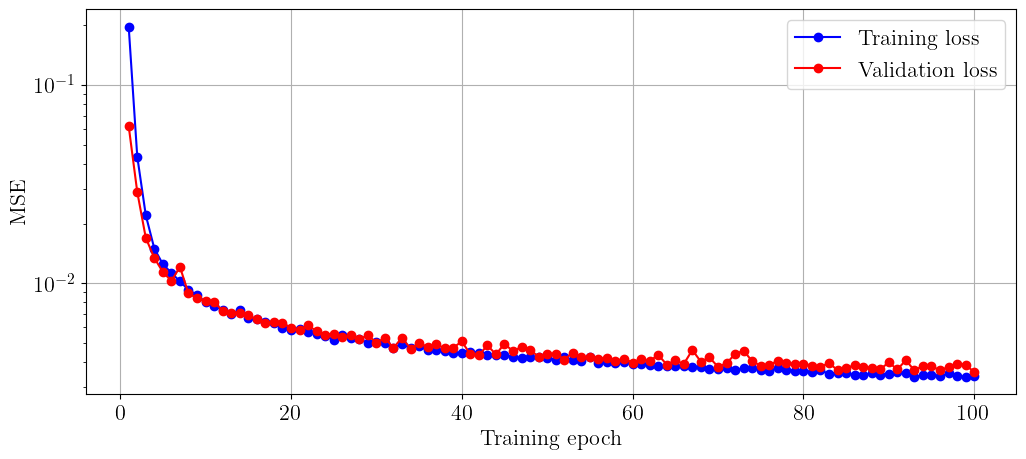

In [31]:
train_loss = training_history.history["loss"]
val_loss = training_history.history["val_loss"]

plt.figure(figsize=(12, 5))
plt.plot([i+1 for i in range(len(train_loss))], train_loss, '-o', color="blue", label="Training loss")
plt.plot([i+1 for i in range(len(val_loss))], val_loss, '-o', color="red", label="Validation loss")
plt.legend()
plt.xlabel("Training epoch")
plt.ylabel("MSE")
plt.yscale('log')
plt.show()

After training, the trained network is saved in the SVD model object, like so:

In [32]:
training_model.svd_model[first_filter]["model"] = model

## Generating the lightcurve from the surrogate model output

We now have a trained emulator which we can query for any input of parameter values of our KN model. However, the output of the neural network is the SVD projection of the lightcurve data, which is not what we want. Hence, when calling the neural network, we have to "undo" the SVD decomposition in order to get the lightcurves. This step is implemented in the `calc_lc` method of `nmma/em/utils`. At the same time, this function "undoes" the normalization step, and goes from normalized lightcurve data to raw (original) lightcurve data.

Let us look into how this is done for an example lightcurve from our set.

In [33]:
# Get the normalized parameters of the first lightcurve of our dataset
idx = 0

print("Example parameters for input in surrogate model:")
key = list(training_data.keys())[idx]
example_parameters = [training_data[key][param] for param in parameters]
example_parameters = np.array(example_parameters)
print(example_parameters)

# Get time grid
t = dat["t"].values 
# Get the magnitude of this filter
_, mAB = nmma.em.lightcurve_generation.calc_lc(t,
                                    example_parameters, 
                                    svd_mag_model = training_model.svd_model, 
                                    interpolation_type="tensorflow", 
                                    filters = [first_filter], 
                                    mag_ncoeff = svd_ncoeff
                                    )

Example parameters for input in surrogate model:
[-2.30103  0.12     0.3     -1.30103  0.03    25.84   ]


In [34]:
# Fetch the raw data of the first filter of the first lightcurve for this comparison
example = training_data[list(training_data.keys())[idx]]
raw_lightcurve = example['data'][:, idx]
len(raw_lightcurve)

100

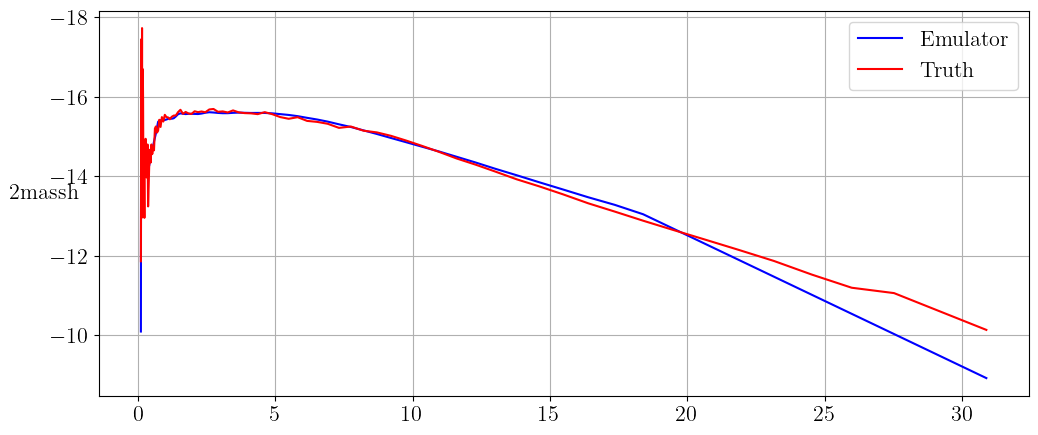

In [35]:
fig, ax = plt.subplots(figsize=(12, 5))
# Plot the surrogate output
plt.plot(t, mAB[first_filter], color="blue", label = "Emulator")
# Also plot the raw data (also processed, interpolated etc)
plt.plot(t, raw_lightcurve, color = "red", label = "Truth")
plt.ylabel(first_filter, rotation=0)
ax.invert_yaxis()
plt.legend()
plt.show()

We see that the surrogate model has good performance for early times. For later times, there is some deviation, which however might be less relevant for real observations. 

Now, we have a trained surrogate model to generate synthetic lightcurves for any parameter value of the `Bu2022Ye` model.